In [26]:
!pip install yfinance statsmodels

# **Import Libraries**

In [91]:
import yfinance as yf # yfinance: A package to download historical market data (like stock prices) from Yahoo Finance.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# statsmodels: A package for statistical modeling in Python. It provides classes and functions for estimation of many different statistical models, as well as for conducting statistical tests.

# **Downloading Historical Stock Data**

In [7]:
tickers = ['AXISBANK.NS', 'SBIN.NS']
start_date = '2020-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start = start_date, end = end_date)['Close']
data.dropna(inplace=True)

/tmp/ipython-input-7-1166605934.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start = start_date, end = end_date)['Close']
[*********************100%***********************]  2 of 2 completed


In [8]:
data

Ticker,AXISBANK.NS,SBIN.NS
Date,,
2020-01-01,745.586914,308.602539
2020-01-02,753.802612,313.077759
2020-01-03,739.860779,307.910522
2020-01-06,720.242798,294.346619
2020-01-07,722.732361,293.792938
...,...,...
2024-12-23,1078.228516,804.986267
2024-12-24,1077.978760,796.065369
2024-12-26,1075.780518,796.457520


# **Visuliazation of Price Movements**

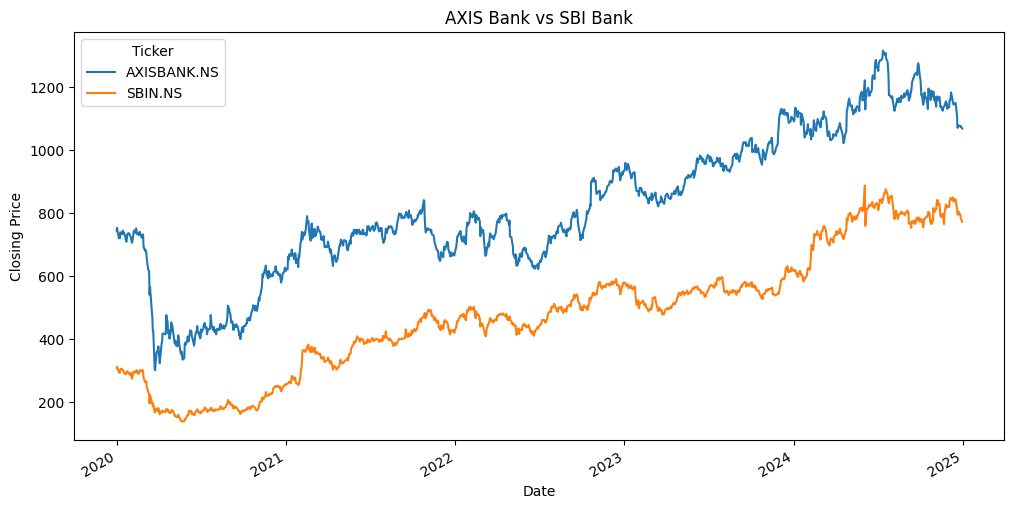

In [11]:
data.plot(figsize=(12,6), title = 'AXIS Bank vs SBI Bank')
plt.ylabel('Closing Price')
plt.show()

# **Caluculate the Plot by Spread (Normal Method)**

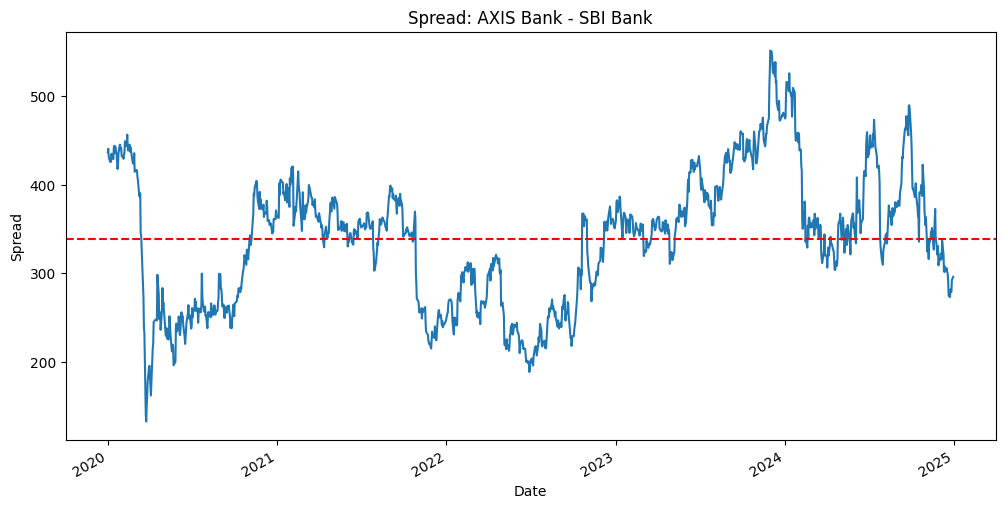

In [12]:
data['Spread'] = data['AXISBANK.NS'] - data['SBIN.NS']
data['Spread'].plot(figsize=(12,6), title = 'Spread: AXIS Bank - SBI Bank')
plt.axhline(data['Spread'].mean(),color='r', linestyle='--', label='Mean')
plt.ylabel('Spread')
plt.show()


 **ADF(Augmented Dickey-Fuller) Test on Spread (Mean-Reversion Check)**

Why use ADF in pair trading?
In pair trading, we assume:

. Two stocks (e.g., AXIS Bank and SBI Bank) move closely together.

. Their spread should hover around a long-term average (mean).

. The ADF test helps statistically confirm this mean-reverting behavior.

In [13]:
ADF_Result = adfuller(data['Spread'])
print(f'ADF Statistic: {ADF_Result[0]}')
print(f'P-Value: {ADF_Result[1]}')
if ADF_Result[1] < 0.05:
  print(" The Spread is mean-reverting (p < 0.05).")
else:
  print(" The Spread is not mean-reverting.")

ADF Statistic: -3.0973983591129968
P-Value: 0.026746321604498576
 The Spread is mean-reverting (p < 0.05).


 **Calculating Thresholds**

In [17]:
mean = data['Spread'].mean()
std = data['Spread'].std() # standard deviation measures how much the spread typically varies from the mean.
Upper = mean + std
lower = mean - std

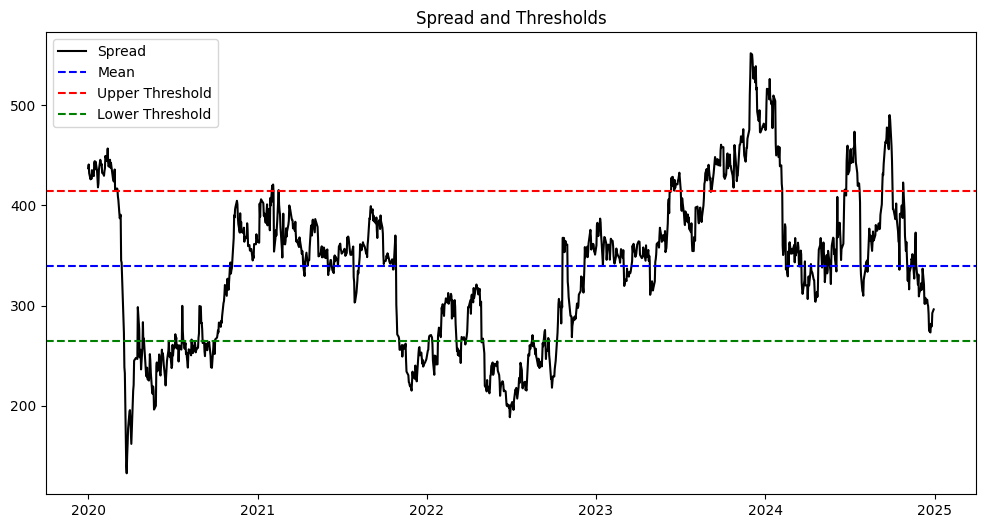

In [18]:
# Plotting Spread and Thresholds

plt.figure(figsize=(12,6))
plt.plot(data['Spread'], label = 'Spread', color = 'black')

plt.axhline(mean, color = 'blue', linestyle = '--', label = 'Mean')
plt.axhline(Upper, color = 'red', linestyle = '--', label = 'Upper Threshold')
plt.axhline(lower, color = 'g', linestyle = '--', label = 'Lower Threshold')

plt.title('Spread and Thresholds')
plt.legend()
plt.show()

**Generated Trading Signals**

In [27]:
data['Signal'] = 0
data.loc[data['Spread'] > Upper, 'Signal'] = 'Sell'  # Short AXISBANK, Long SBIN
data.loc[data['Spread'] < lower, 'Signal'] = 'Buy'   # Long AXISBANK, Short SBIN

# Forward fill the signal and shift to avoid lookahead bias
data['Position'] = data['Signal'].shift()

data[['Spread', 'Signal', 'Position']]


/tmp/ipython-input-27-3341916426.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Sell' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['Spread'] > Upper, 'Signal'] = 'Sell'  # Short AXISBANK, Long SBIN


Ticker,Spread,Signal,Position
Date,,,
2020-01-01,436.984375,Sell,None
2020-01-02,440.724854,Sell,Sell
2020-01-03,431.950256,Sell,Sell
2020-01-06,425.896179,Sell,Sell
2020-01-07,428.939423,Sell,Sell
...,...,...,...
2024-12-23,273.242249,0,0
2024-12-24,281.913391,0,0
2024-12-26,279.322998,0,0


# **Calculating plot by Log Prices (Remove Skewness)**

**Log prices are commonly used in financial time series for these reasons:**

1. **Stabilizes Variance (Removes Skewness)
Stock prices grow exponentially.**

. Taking log turns exponential growth into linear → easier for modeling and statistical analysis.

2. **Simplifies Return Calculations
Log returns are calculated as:**

log
⁡
(
𝑃
𝑡/
𝑃
𝑡
−
1
)
=
log
⁡
(
𝑃
𝑡
)
−
log
⁡
(
𝑃
𝑡
−
1
)

So, if you store log prices, log returns become just differences.

3. **Improves Stationarity
Many raw price series are non-stationary (trend over time).**

. Taking log often helps make the series closer to stationary, which is required for statistical tests like ADF or modeling like OLS regression.

In [28]:
import numpy as np

In [38]:
tickers = ['AXISBANK.NS', 'SBIN.NS']
start_date = '2020-01-01'
end_date = '2024-12-31'

df = yf.download(tickers, start = start_date, end = end_date)['Close']
df.dropna(inplace=True)

/tmp/ipython-input-38-3494207811.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start = start_date, end = end_date)['Close']
[*********************100%***********************]  2 of 2 completed


**Log Prices**

In [39]:
df["Log_AXISBANK"] = np.log(df["AXISBANK.NS"])
df["Log_SBIBANK"] = np.log(df["SBIN.NS"])


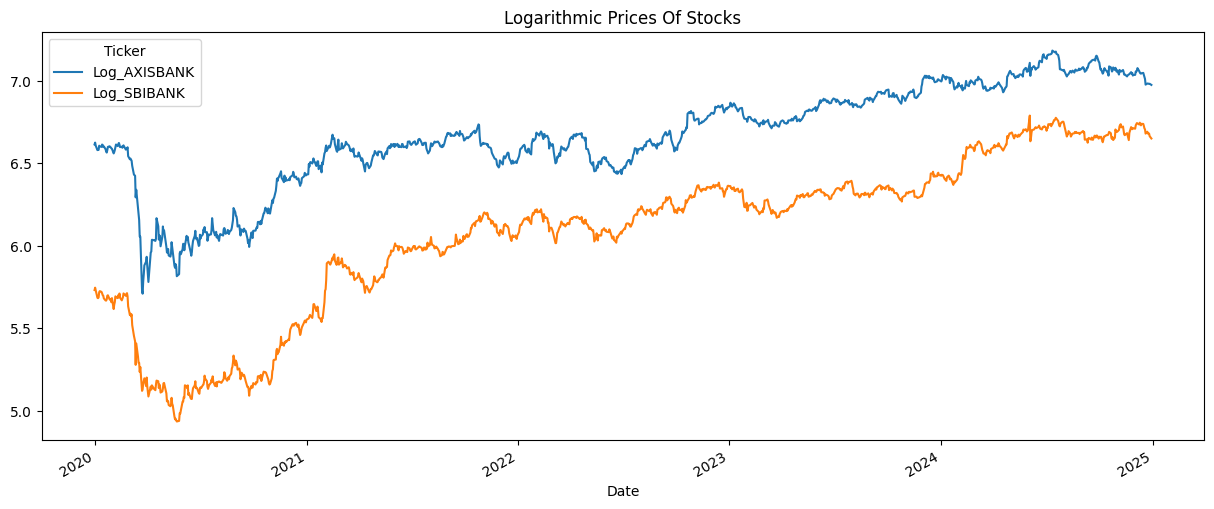

In [45]:
df[["Log_AXISBANK", "Log_SBIBANK"]].plot(figsize=(15,6))
plt.title("Logarithmic Prices Of Stocks")
plt.show()

In [40]:
df[["Log_AXISBANK","Log_SBIBANK"]]

Ticker,Log_AXISBANK,Log_SBIBANK
Date,,
2020-01-01,6.614172,5.732054
2020-01-02,6.625131,5.746452
2020-01-03,6.606462,5.729809
2020-01-06,6.579588,5.684758
2020-01-07,6.583039,5.682875
...,...,...
2024-12-23,6.983075,6.690825
2024-12-24,6.982843,6.679681
2024-12-26,6.980802,6.680174


**Correlation**

In [46]:
print("Correlation coefficient of two "+"\033[1m"+"Logarithmic Prices"+"\033[0m"+" are calculated as, \n"\
      ,df[["Log_AXISBANK","Log_SBIBANK"]].corr(method='pearson', min_periods=1))

Correlation coefficient of two Logarithmic Prices are calculated as, 
 Ticker        Log_AXISBANK  Log_SBIBANK
Ticker                                 
Log_AXISBANK      1.000000     0.953273
Log_SBIBANK       0.953273     1.000000


**Regression to get Spread**

In [47]:
x = df["Log_SBIBANK"]  # independent variable (X)
y = df["Log_AXISBANK"] # dependent variable (Y)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y) # log(AXISBANK)=slope×log(SBIN)+intercept

predicted = slope * x + intercept # Calculates the predicted log price of AXISBANK using the regression model.

spread = y - predicted # his spread tells how far AXISBANK is from its expected value based on SBIN.

spread_std = (spread - spread.mean()) / spread.std() # Helps identify whether the spread is significantly above or below average.

In [48]:
print("slope: %f    intercept: %f" % (slope, intercept))

slope: 0.623373    intercept: 2.876838


**.** **Slope** = 0.623
Tells you the rate of change of AXISBANK's log-price with respect to SBIN's log-price.

Since it's < 1, it means AXISBANK moves less aggressively than SBIN.

Positive slope → they tend to move in the same direction.

**. Intercept** = 2.876
This is the value of log(AXISBANK) when log(SBIN) = 0.

In practical terms, it shifts the regression line vertically.

Not as important as slope for trading, but required for computing the predicted price.

In [49]:
print("R-squared is calculated as: %f" % r_value**2)

R-squared is calculated as: 0.908729


. A high R² like this is very good — it suggests strong linear co-movement between the two.

. This is a positive sign for pairs trading since it implies strong correlation and good predictability.

In [50]:
print("Standart Error is calculated as: %f" % std_err)

Standart Error is calculated as: 0.005622


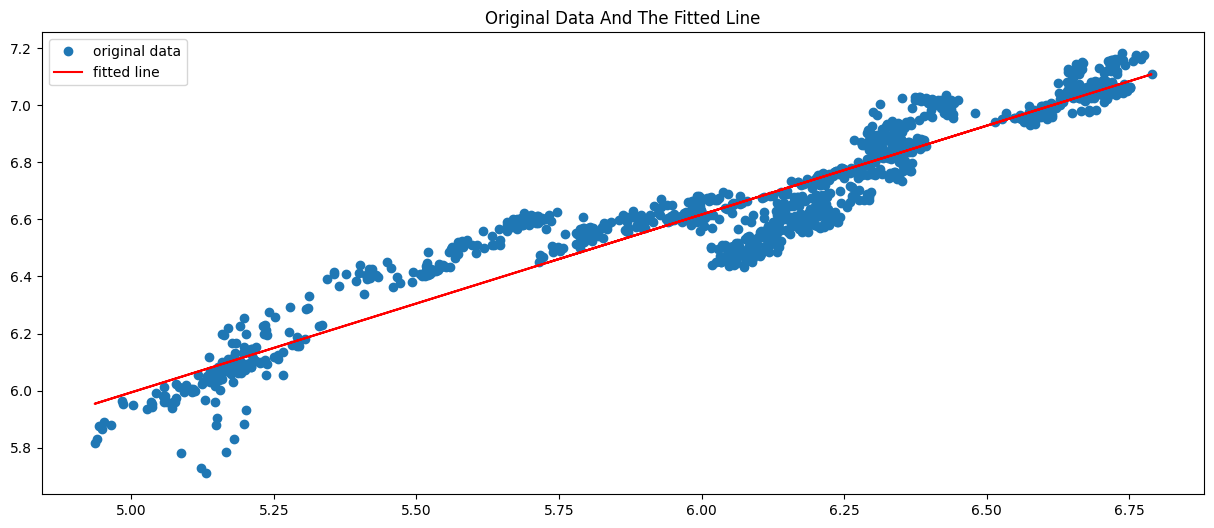

In [52]:
plt.figure(figsize=(15,6))
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.title("Original Data And The Fitted Line")
plt.legend()
plt.show()

**Plotting Spread**

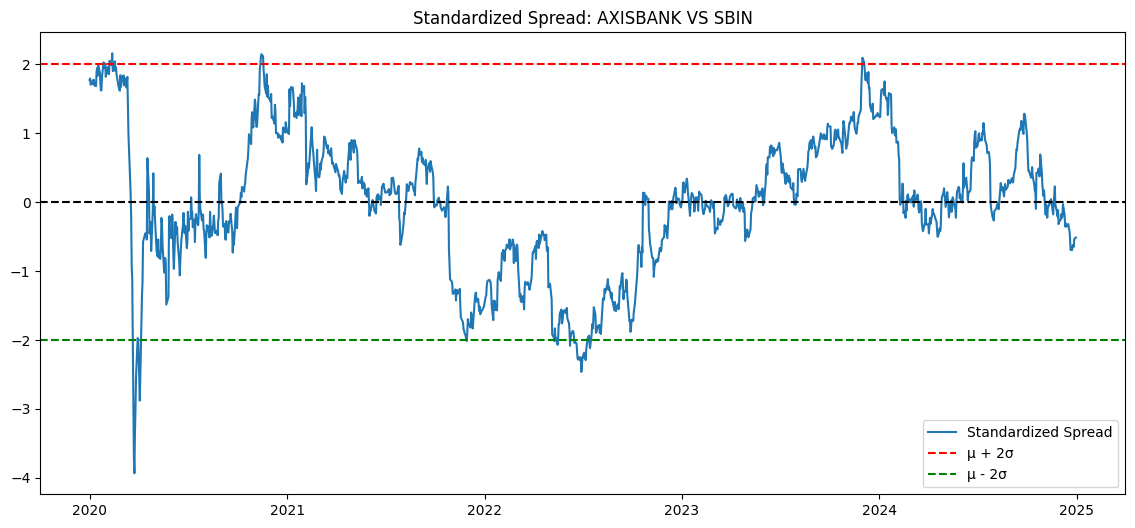

In [44]:
plt.figure(figsize=(14,6))
plt.plot(spread_std, label="Standardized Spread")
plt.axhline(2, color='r', linestyle = '--', label = 'μ + 2σ')
plt.axhline(-2, color='g', linestyle = '--', label = 'μ - 2σ')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title("Standardized Spread: AXISBANK VS SBIN")
plt.legend()
plt.show()

**Generating Trading Signals**

In [102]:
df['spread'] = spread_std
df['long'] = np.where(df['spread'] < -2, 1, 0) # Trigger a long entry when spread < -2
df['short'] = np.where(df['spread'] > +2, 1, 0) # Trigger a short entry when spread > +2

# Trading Positions (pos)
df['AXIS_Pos'] = 0 # 1 = Long, -1 = Short, 0 = No position
df['SBI_Pos'] = 0

# Long for Position Updates

for i in range(1, len(df)):
    if df['spread'].iloc[i] > 2:
        df.loc[df.index[i], 'AXIS_Pos'] = -1 # AXISBANK is relatively overpriced, SBIN is underpriced.
        df.loc[df.index[i], 'SBI_Pos'] = 1

    elif df['spread'].iloc[i] < -2:
        df.loc[df.index[i], 'AXIS_Pos'] = 1 # AXISBANK is underpriced, SBIN is overpriced.
        df.loc[df.index[i], 'SBI_Pos'] = -1
    else:
        df.loc[df.index[i], 'AXIS_Pos'] = df.loc[df.index[i-1], 'AXIS_Pos'] # Hold previous position (no change, maintain the trade).
        df.loc[df.index[i], 'SBI_Pos'] = df.loc[df.index[i-1], 'SBI_Pos']



**Calculate Strategy Returns**

In [103]:
df['AXISBANK_ret'] = df['AXISBANK.NS'].pct_change()
df['SBIN_ret'] = df['SBIN.NS'].pct_change()
df['Strategy'] = df['AXIS_Pos'].shift(1) * df['AXISBANK_ret'] + df['SBI_Pos'].shift(1) * df['SBIN_ret']
df['Cumulative'] = (1 + df['Strategy'].fillna(0)).cumprod()

In [107]:
df[['AXISBANK_ret', 'SBIN_ret', 'Strategy', 'Cumulative']]


,AXISBANK_ret,SBIN_ret,Strategy,Cumulative
0,NaN,NaN,NaN,1.0
1,0.037594,-0.119362,0.0,1.0
2,0.071162,0.022065,0.0,1.0
3,0.137570,-0.066517,0.0,1.0
4,0.102436,0.011199,0.0,1.0
...,...,...,...,...
1995,0.000779,-0.000892,0.0,1.0
1996,0.004188,0.005813,0.0,1.0
1997,0.000933,0.000495,0.0,1.0
1998,-0.002450,0.005186,0.0,1.0


**Ploting Cumulative Returns**

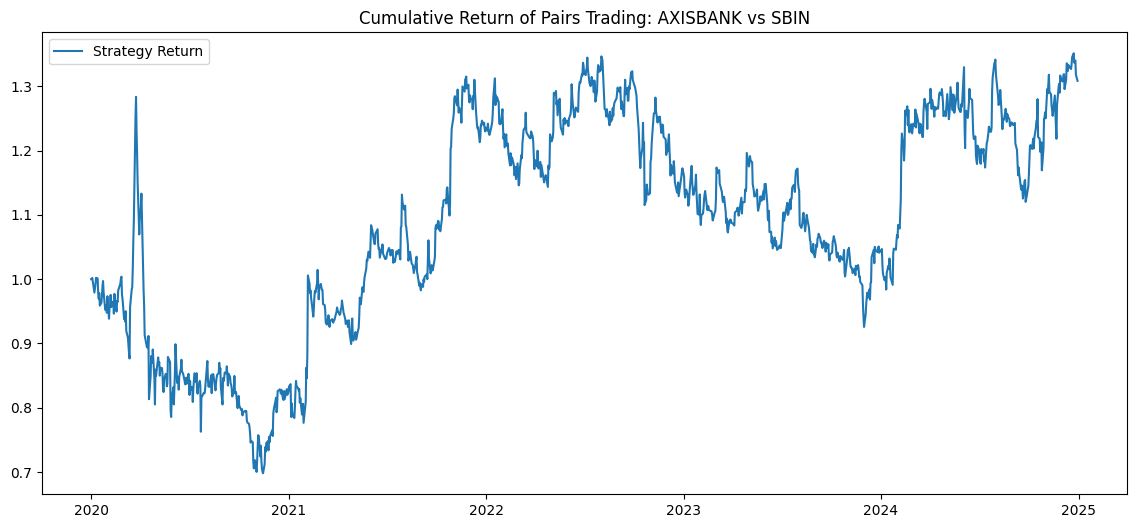

In [108]:
plt.figure(figsize=(14,6))
plt.plot(data['Cumulative'], label='Strategy Return')
plt.title('Cumulative Return of Pairs Trading: AXISBANK vs SBIN')
plt.legend()
plt.show()